In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

## Online learning
This is the fancy word for machine learning when you feed your data in little-by-little.  This could be just because you cannot hold all of the data in memory/disk at once, or because you are getting new data over time and need to feed it into an existing model.

## Out-of-core learning
This is the fancy word for machine learning when your data doesn't all fit into memory / fit on one computer.  Online learning algorithms give, in particular, out-of-core learning algorithms.  

(You could imagine differences in desired behavior -- e.g., an online learner might depend on the order in which you feed in the data, so if you do not want this you might shuffle the data first.)

## Data streams

In online learning, you often want a pipeline operating on instances in a __stream__.  The point of streaming (i.e., what does streaming actually mean) is to use constant memory by keeping around only a bounded amount of history / state.

The three steps are:
1. **Ingest data (in a _stream_ or in _chunks_)**: This means do not store everything.  In Python this usually means something like using a generator / a library that does this automatically.
2. **Extract features (in a _stateless_ way)**: Being stateless means that your feature extractor should not store (much, or a growing amount of) information.  

   This is most relevant in textual tasks, or when you have categorical features whose set of possible values is not known ahead of time -- the standard solution in both cases is to use the [_hashing trick_](http://scikit-learn.org/dev/modules/feature_extraction.html#feature-hashing).  We already mentioned this in the context of the `HashingVectorizer` for bag-of-words, but the same can be done for other categorical variables (see the [FeatureHasher](http://scikit-learn.org/dev/modules/generated/sklearn.feature_extraction.FeatureHasher.html#sklearn.feature_extraction.FeatureHasher))
3. **Update the learner**: This means to use the features to update the learned coefficients of the model.  In scikit-learn this is the `partial_fit` method that some (but not all) learners have.  

  In general there is some question of _what this means_ for any given learner: i.e., are more recent test cases given greater weight in the optimization problem being solved, and if so how much greater? 

  (The answer is usually yes -- they are given greater weight.  This behavior is often desired -- where it might not be is if you are using an online learner to do out-of-core learning on data that does not have a natural ordering by relevance / time, in which case a shuffling step will help.) 

## Online learning in Scikit-learn

It turns out that scikit-learn already has some support for online learning strategies.  See http://scikit-learn.org/dev/modules/scaling_strategies.html#incremental-learning for a full list, but some notable examples are:

1. Stochastic gradient descent methods: `SGDClassifier` and `SGDRegressor`.  These can be used to train the standard _linear models_:  _linear regressions_ for regression; and, _logistic regressions_ and _SVM_ for classification.

  Some caveats: 
   - In contrast to some other linear learners, SGD methods care a lot that the data be _scaled_ 
   - There are extra (numerical) parameters that must be tuned to ensure good learning.

2. Naive Bayes methods: `MultinomialNB`, `BernoulliNB`.  It's just counting, after all.

3. (Unsupervised) K-Means clustering: `MiniBatchKMeans`.

####For more details:
http://scikit-learn.org/dev/modules/scaling_strategies.html

## Out-of-core methods in Scikit-learn and Spark MLlib

There are out-of-core algorithms that do not depend on an online algorithm.  That is, you distribute the data and do some iterative training step across a cluster -- rather than feeding in the data bit by bit and (e.g.,) exponentially weighting the recent test cases more.

  So for instance, while scikit-learn's SGD learners will weight recent test cases higher (and thus depends on the ordering and the  size of the batches that you feed into `partial_fit`), the logistic regression that we saw implemented in Spark last time does not. 
  
  Similarly the algorithms in Spark's MLLib tend to be out-of-core but _not necessarily_ online.  See the documentation link below for more information, but notable entries are:
   - SGD for linear models: (regularized) linear regressions; logistic regressions and SVM.
   - Naive bayes
   - Decision trees (you should look into the exact state of random forest training, though)
   - Neural networks (you should look into exactly which variants, and how good the learning really is...)
   - k-means clustering
   - non-negative matrix factorizations
   
#### For more details:
http://spark.apache.org/docs/latest/mllib-guide.html

## Other scalable machine learning libraries

The above two sets of libraries are by no means exhaustive.  However the further you move from the "very standard" algorithms (note the large intersection of the above two lists) the more novelty and engineering work tends to be involved -- and it's probably most practical to hope that someone else has already done it for you.  

In addition to Spark/MLLib above, there is at least the following additional place to look at for this:

- [Mahout](https://mahout.apache.org/) is an Apache project that aims to provide a toolbox of "scalable" machine learning algorithms. It used to be based on Hadoop/MR, and now aims to move towards being based on Spark.  See
https://mahout.apache.org/users/basics/algorithms.html for a list of implemented algorithms (some in MR, some only on a single machine, at present very little is based on Spark).

In [2]:
from pylib.reuters_parser import iter_minibatches, get_minibatch, stream_reuters_documents
from sklearn.pipeline import Pipeline
from sklearn.base import ClassifierMixin 
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

from collections import defaultdict
import numpy as np
import time
import matplotlib.pyplot as plt
import sys

In [3]:
MINIBATCH_SIZE = 1000

# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, MINIBATCH_SIZE)

class PartialFitPipelineClassifier(ClassifierMixin):
    """
    A pipeline for partial fit.
    Ensure that the transformers do not need to be fit
    """
    def __init__(self, steps):
        self._steps = steps
        self._transformers = steps[:-1]
        self._estimator = steps[-1]
        
    def _transform(self, X):
        Xtrans = X
        for step in self._transformers:
            Xtrans = step.transform(Xtrans)
        return Xtrans
            
    def partial_fit(self, X, y, **kwargs):
        Xtrans = self._transform(X)
        return self._estimator.partial_fit(Xtrans, y, **kwargs)
    
    def predict(self, X):
        Xtrans = self._transform(X)
        return self._estimator.predict(Xtrans)
    
clf = PartialFitPipelineClassifier([
    HashingVectorizer(decode_error='ignore', n_features=2 ** 18, non_negative=True),
    SGDClassifier()
])


In [4]:
X_test, y_test = get_minibatch(data_stream, 1000)
all_classes = np.array([0, 1])
times = []
samples = []
scores = []
for i, (X_train, y_train) in enumerate(minibatch_iterators):
    if i > 10:
        break
    start_time = time.time()
    clf.partial_fit(X_train, y_train, classes=all_classes)
    times += [time.time() - start_time]
    samples += [len(y_train)]
    scores += [clf.score(X_test, y_test)]
    print "Time: %2.2f secs, Iterations: %6d, Score: %f" % (sum(times), sum(samples), scores[-1])

downloading dataset (once and for all) into /home/vagrant/scikit_learn_data/reuters
untarring Reuters dataset...
done.
Time: 0.20 secs, Iterations:    962, Score: 0.908530
Time: 0.49 secs, Iterations:   1931, Score: 0.929085
Time: 0.67 secs, Iterations:   2847, Score: 0.940391
Time: 0.89 secs, Iterations:   3768, Score: 0.951696
Time: 1.05 secs, Iterations:   4445, Score: 0.953751
Time: 1.22 secs, Iterations:   5200, Score: 0.955807
Time: 1.44 secs, Iterations:   6182, Score: 0.946557
Time: 1.64 secs, Iterations:   7058, Score: 0.939363
Time: 1.78 secs, Iterations:   7633, Score: 0.951696
Time: 2.02 secs, Iterations:   8612, Score: 0.944502
Time: 2.24 secs, Iterations:   9599, Score: 0.956835


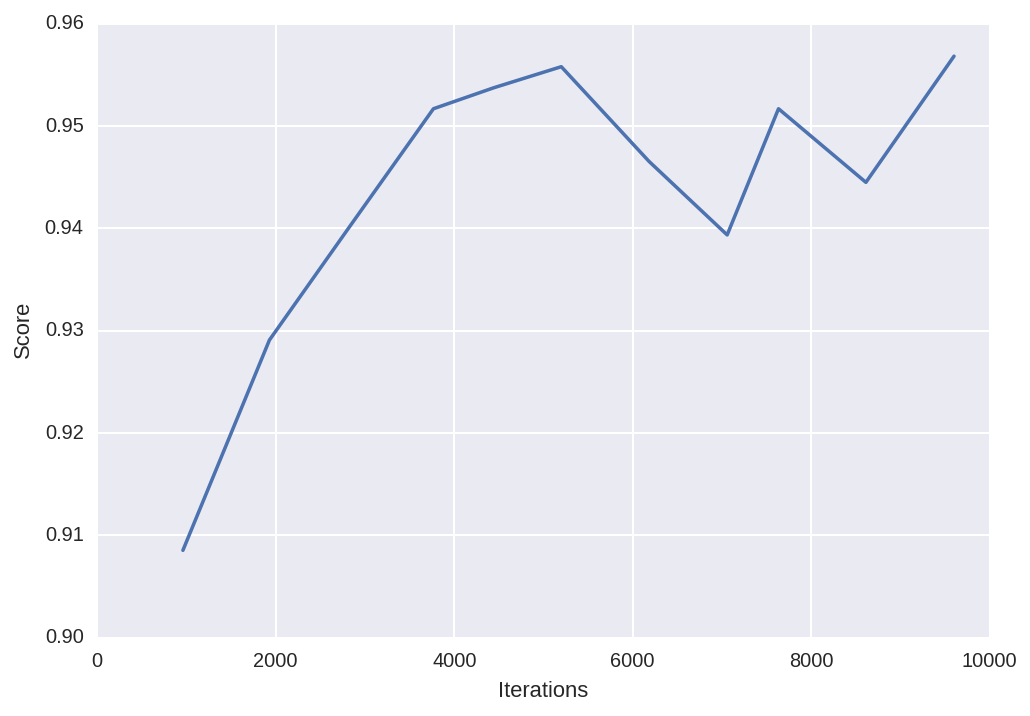

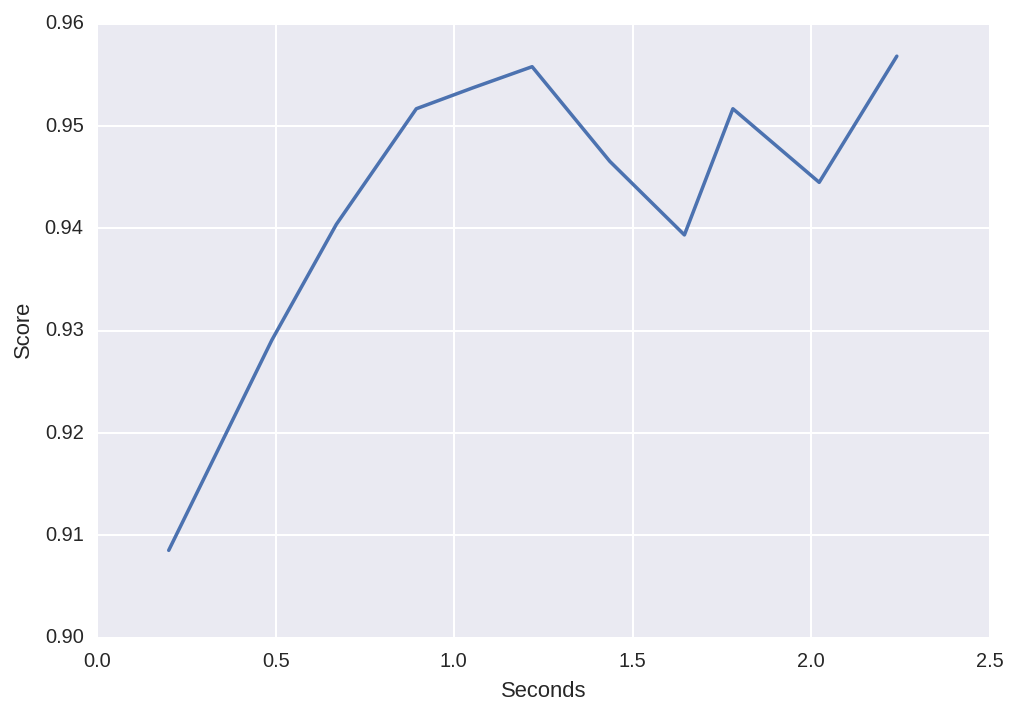

In [5]:
plt.plot(np.cumsum(samples), scores)
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.show()

plt.plot(np.cumsum(times), scores)
plt.xlabel('Seconds')
plt.ylabel('Score')
plt.show()

In [6]:
MINIBATCH_SIZE = 1000

# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, MINIBATCH_SIZE)

def add_vectorizer(clf):
    return PartialFitPipelineClassifier([
        HashingVectorizer(decode_error='ignore', n_features=2 ** 18, non_negative=True),
        clf
    ])

classifiers = {
    'SGD': add_vectorizer(SGDClassifier()),
    'Perceptron': add_vectorizer(Perceptron()),
    'NB Multinomial': add_vectorizer(MultinomialNB(alpha=0.01)),
    'Passive-Aggressive': add_vectorizer(PassiveAggressiveClassifier()),
}

In [7]:
X_test, y_test = get_minibatch(data_stream, 1000)
all_classes = np.array([0, 1])
times = defaultdict(lambda: [])
samples = defaultdict(lambda: [])
scores = defaultdict(lambda: [])
for i, (X_train, y_train) in enumerate(minibatch_iterators):
    if i > 10:
        break
    sys.stdout.write("\nIteration %2d" % i)
    for clf_name, clf in classifiers.iteritems():
        sys.stdout.write(", %s" % clf_name)
        start_time = time.time()
        clf.partial_fit(X_train, y_train, classes=all_classes)
        times[clf_name] += [time.time() - start_time]
        samples[clf_name] += [len(y_train)]
        scores[clf_name] += [clf.score(X_test, y_test)]
    


Iteration  0, Passive-Aggressive, Perceptron, SGD, NB Multinomial
Iteration  1, Passive-Aggressive, Perceptron, SGD, NB Multinomial
Iteration  2, Passive-Aggressive, Perceptron, SGD, NB Multinomial
Iteration  3, Passive-Aggressive, Perceptron, SGD, NB Multinomial
Iteration  4, Passive-Aggressive, Perceptron, SGD, NB Multinomial
Iteration  5, Passive-Aggressive, Perceptron, SGD, NB Multinomial
Iteration  6, Passive-Aggressive, Perceptron, SGD, NB Multinomial
Iteration  7, Passive-Aggressive, Perceptron, SGD, NB Multinomial
Iteration  8, Passive-Aggressive, Perceptron, SGD, NB Multinomial
Iteration  9, Passive-Aggressive, Perceptron, SGD, NB Multinomial
Iteration 10, Passive-Aggressive, Perceptron, SGD, NB Multinomial

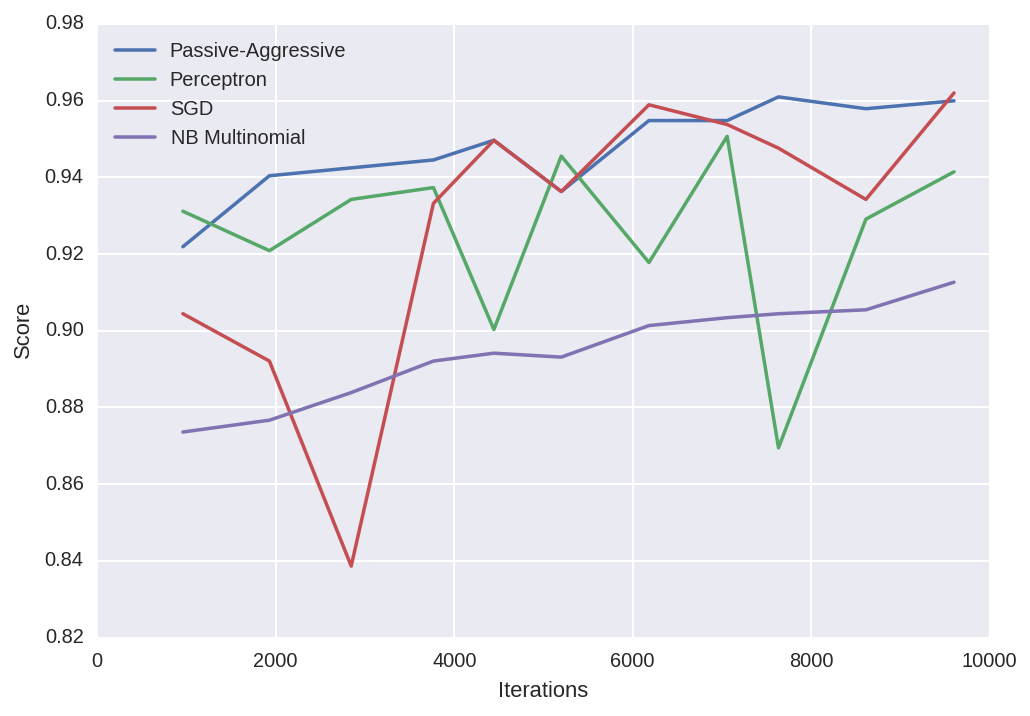

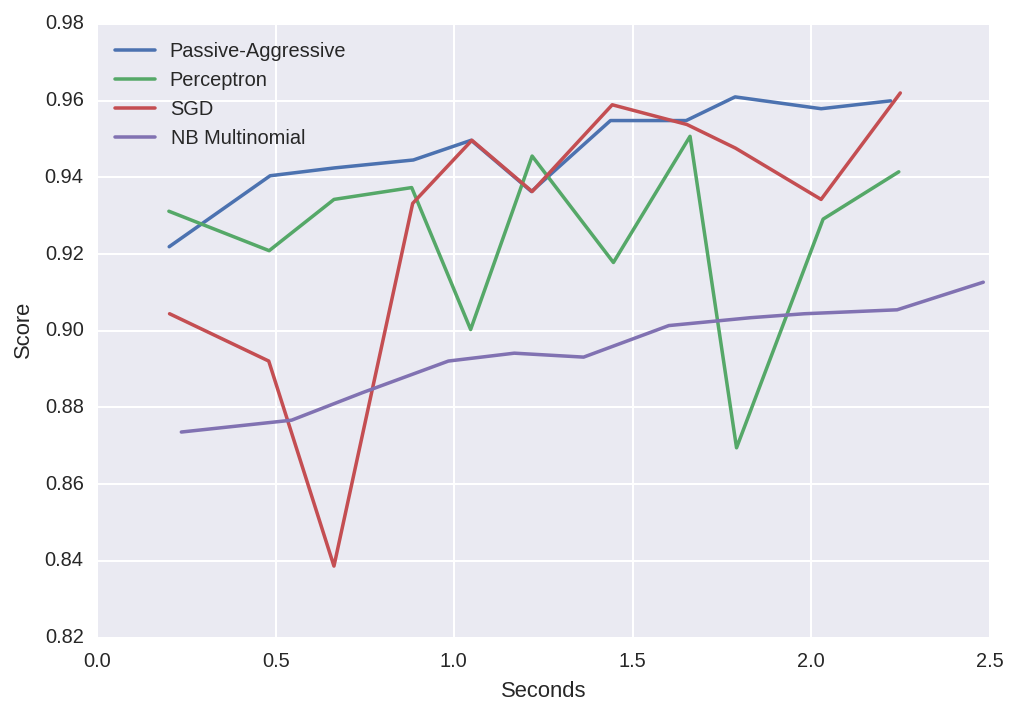

In [8]:
for clf_name in classifiers:
    plt.plot(np.cumsum(samples[clf_name]), scores[clf_name], label=clf_name)
plt.xlabel('Iterations')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.show()

for clf_name in classifiers:
    plt.plot(np.cumsum(times[clf_name]), scores[clf_name], label=clf_name)
plt.xlabel('Seconds')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.show()

### Exit Tickets
1. Of the models we spoke about, which is more suitable for mapreduce, SGD or Naive Bayes?  How would you implement either?
1. How would you adapt learning for SGD mapreduce?
1. Explain the benefits/drawbacks of batch versus minibatch versus online/streaming learning for predictive modeling.

*Copyright &copy; 2015 The Data Incubator.  All rights reserved.*